In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

users = pd.read_csv("../data/users.csv")
transactions = pd.read_csv("../data/transactions.csv")
market = pd.read_csv("../data/market_data.csv")
clusters = pd.read_csv("../intermediate/user_features_clustered.csv")

transactions = transactions.merge(clusters[['user_id', 'cluster_label']], on='user_id', how='left')

transactions.head()

,user_id,transaction_type,date,amount,asset,cluster_label
0,1,buy,2023-10-06,872.88,ETH,1
1,1,sell,2022-05-13,783.42,ETH,1
2,1,buy,2021-06-08,983.42,AAPL,1
3,1,sell,2022-01-05,776.96,ETH,1
4,1,sell,2024-08-13,749.57,AAPL,1


In [7]:

tmp = transactions.groupby(['cluster_label', 'asset'])['amount'].sum()
tmp = tmp.groupby(level=0).apply(lambda x: x / x.sum())


index_df = pd.DataFrame(tmp.index.tolist(), columns=['cluster_label', 'cluster_label_2', 'asset'])


tmp_df = pd.concat([index_df, tmp.reset_index(drop=True)], axis=1)

tmp_df = tmp_df[['cluster_label', 'asset', 'amount']]
tmp_df = tmp_df.rename(columns={'amount': 'weight'})

cluster_portfolios = tmp_df
cluster_portfolios.head()


,cluster_label,asset,weight
0,0,AAPL,0.012519
1,0,BTC,0.232814
2,0,ETH,0.100429
3,0,EURUSD,0.110626
4,0,GLD,0.148664


In [8]:
#Calculating Asset Based Returns
market['return'] = market.groupby('asset')['price'].pct_change()
asset_returns = market.pivot(index='date', columns='asset', values='return')
asset_returns = asset_returns.fillna(0)
asset_returns.head()


asset,AAPL,BTC,ETH,EURUSD,GLD,S&P500,TSLA
date,,,,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,-0.008536,-0.013197,-0.005827,0.012452,-0.006894,0.003689,-0.007924
2020-01-03,0.003139,-0.003578,-0.007459,-0.015606,-0.005553,0.004274,0.002426
2020-01-04,-0.013588,0.000513,-0.011094,0.005773,0.016567,-0.024340,-0.006757
2020-01-05,0.009063,-0.018882,0.007238,-0.011394,-0.009064,-0.002530,-0.012896


In [9]:
#Cluster Daily Returns
cluster_portfolios['asset'] = cluster_portfolios['asset'].str.strip()
asset_returns.columns = asset_returns.columns.str.strip()


cluster_daily = []

for label in cluster_portfolios['cluster_label'].unique():
    pf = cluster_portfolios[cluster_portfolios['cluster_label'] == label].copy()
    
    assets = pf['asset'].tolist()             
    weights = pf.set_index('asset')['weight']  
    
    
    assets_in_data = [a for a in assets if a in asset_returns.columns]
    
    w_ret = asset_returns[assets_in_data].mul(weights[assets_in_data], axis=1).sum(axis=1)
    
    df = pd.DataFrame({
        'date': asset_returns.index,
        'cluster_label': label,
        'daily_return': w_ret.values
    })
    cluster_daily.append(df)

cluster_daily = pd.concat(cluster_daily, ignore_index=True)
cluster_daily.head()


,date,cluster_label,daily_return
0,2020-01-01,0,0.000000
1,2020-01-02,0,-0.003238
2,2020-01-03,0,-0.002611
3,2020-01-04,0,-0.005734
4,2020-01-05,0,-0.008308


# Cluster Daily Returns
For each cluster, daily portfolio returns are calculated by weighting each asset's daily return according to the cluster's portfolio composition. The results are combined into `cluster_daily` for further analysis.


In [10]:
#Bring each cluster together (for time series)
cluster_ts = cluster_daily.pivot(index='date', columns='cluster_label', values='daily_return')
cluster_ts.head()


cluster_label,0,1,2
date,,,
2020-01-01,0.000000,0.000000,0.000000
2020-01-02,-0.003238,-0.006241,-0.005135
2020-01-03,-0.002611,-0.001238,-0.002006
2020-01-04,-0.005734,-0.009387,-0.007690
2020-01-05,-0.008308,-0.001398,-0.004755


# Cluster Time Series
Pivot `cluster_daily` to create a time series DataFrame `cluster_ts` where each column represents a cluster's daily returns. This structure allows for easy comparison and further time series analysis.


In [11]:
#This shows us the growth of each cluster from the beginning to the present.
cluster_cum = (1 + cluster_ts).cumprod()
cluster_cum.head()


cluster_label,0,1,2
date,,,
2020-01-01,1.000000,1.000000,1.000000
2020-01-02,0.996762,0.993759,0.994865
2020-01-03,0.994160,0.992530,0.992870
2020-01-04,0.988459,0.983213,0.985235
2020-01-05,0.980247,0.981839,0.980550


In [ ]:
#Performance Metrics - Volatility
mean_daily = cluster_ts.mean()
vol_daily = cluster_ts.std()

annual_ret = mean_daily * 252
annual_vol = vol_daily * np.sqrt(252)
#Sharpe Ratio
sharpe = annual_ret / annual_vol

#Max Drawdown
cum_max = cluster_cum.cummax()
drawdown = (cluster_cum - cum_max) / cum_max
max_dd = drawdown.min()

performance = pd.DataFrame({
    'Annualized Return': annual_ret,
    'Annualized Volatility': annual_vol,
    'Sharpe Ratio': sharpe,
    'Max Drawdown': max_dd
})

performance


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
cluster_label,,,,
0,0.040811,0.070870,0.575859,-0.090834
1,0.006255,0.117798,0.053099,-0.333308
2,0.020692,0.085336,0.242480,-0.142206


# Cluster Performance Metrics
Compute key performance metrics for each cluster:
- Annualized Return: Expected yearly return based on daily returns
- Annualized Volatility: Yearly risk measure
- Sharpe Ratio: Risk adjusted return
- Max Drawdown: Maximum peak to trough decline


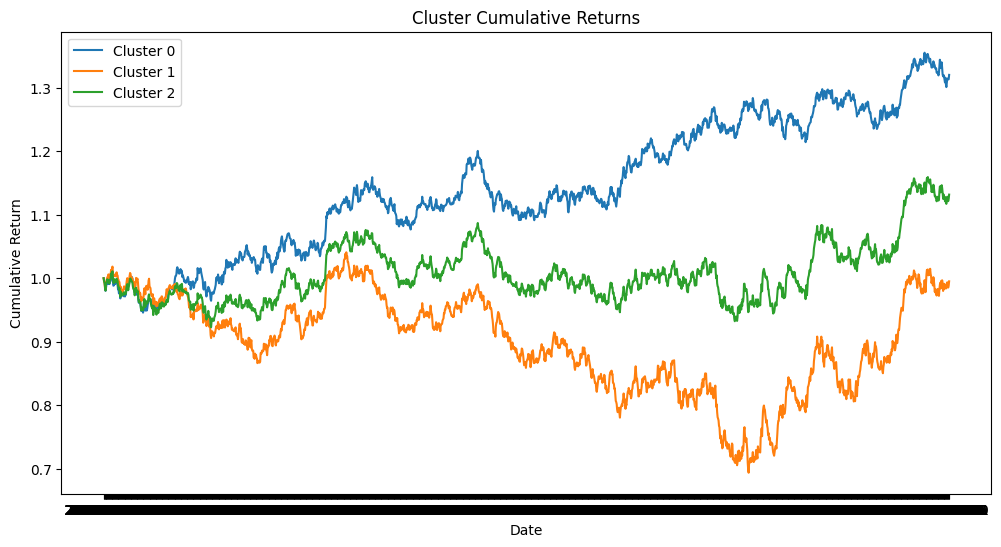

In [ ]:
#Cumulative Returns
plt.figure(figsize=(12,6))
for col in cluster_cum.columns:
    plt.plot(cluster_cum.index, cluster_cum[col], label=f'Cluster {col}')
plt.title("Cluster Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


Cluster Cumulative Returns Analysis

Observation:
The cumulative return plot illustrates the growth of each cluster’s portfolio over time. Clusters with higher exposure to volatile assets show more pronounced swings, while conservative clusters demonstrate steadier growth.

Behavioral Insight:

Clusters with higher transaction activity and risk survey scores tend to accumulate higher returns, but also exhibit larger drawdowns during market dips.

Less active or low risk clusters grow steadily but with lower overall returns.

Portfolio Composition Impact:

Clusters overweight in crypto or high volatility stocks experience sharp peaks and troughs.

Diversified clusters with balanced allocations show smoother cumulative growth.

Risk Adjusted Perspective:

Even if a cluster shows high cumulative return, it is essential to consider volatility and maximum drawdown for a realistic risk assessment.

This cumulative chart should be interpreted alongside Sharpe Ratio and Drawdown metrics for a complete view.

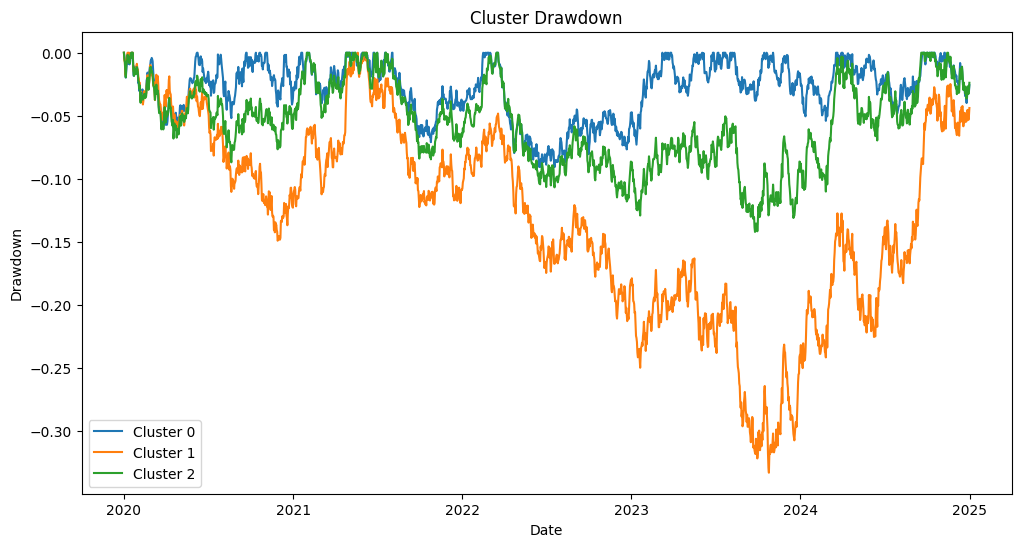

In [14]:
drawdown.index = pd.to_datetime(drawdown.index)
plt.figure(figsize=(12,6))
for col in drawdown.columns:
    plt.plot(drawdown.index, drawdown[col], label=f'Cluster {col}')
plt.title("Cluster Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()


Cluster Drawdown Analysis

Observation:
The drawdown plot shows the peak to trough declines for each cluster over time. It highlights the periods when clusters experienced losses relative to their previous highs.

Behavioral Insight:

Clusters with higher allocation to volatile assets (like crypto) experience deeper and more frequent drawdowns.

Conservative clusters exhibit shallower drawdowns, indicating more stability and lower downside risk.

Risk Adjusted Perspective:

Maximum drawdown alone helps identify worst case scenarios for each cluster.

This visualization, combined with cumulative returns and Sharpe ratios, provides a comprehensive view of risk adjusted performance.

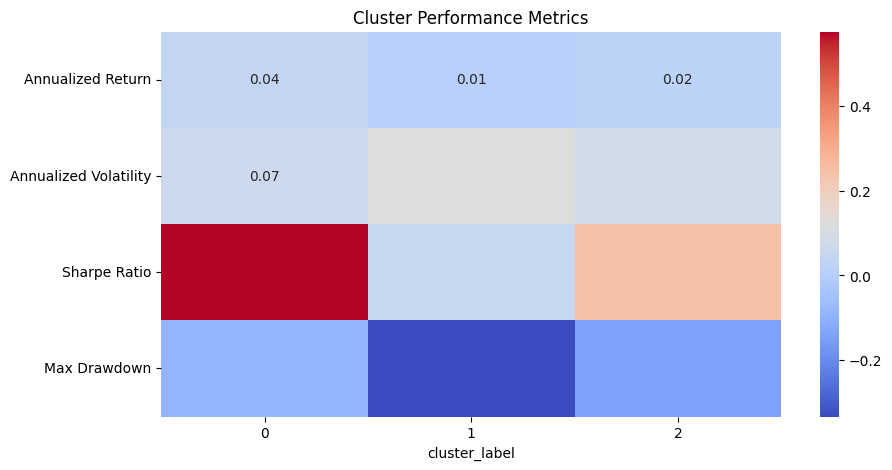

In [15]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(performance.T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cluster Performance Metrics")
plt.show()


Cluster Performance Metrics

Observation:
The heatmap summarizes key performance metrics for each cluster: Annualized Return, Annualized Volatility, Sharpe Ratio, and Maximum Drawdown.

Insights:

Annualized Return: Highlights which clusters delivered the highest growth over the period.

Annualized Volatility: Shows the variability of daily returns; clusters with higher volatility typically correspond to riskier portfolios.

Sharpe Ratio: Indicates risk adjusted returns; higher values suggest better performance relative to risk taken.

Max Drawdown: Measures worst case peak to trough loss, reflecting downside risk for each cluster.

Interpretation:
By comparing these metrics side by side, investors or analysts can quickly identify clusters that offer a favorable balance between returns and risk. High returns with moderate drawdowns and strong Sharpe ratios signal optimal clusters, while high volatility and deep drawdowns indicate higher risk profiles.

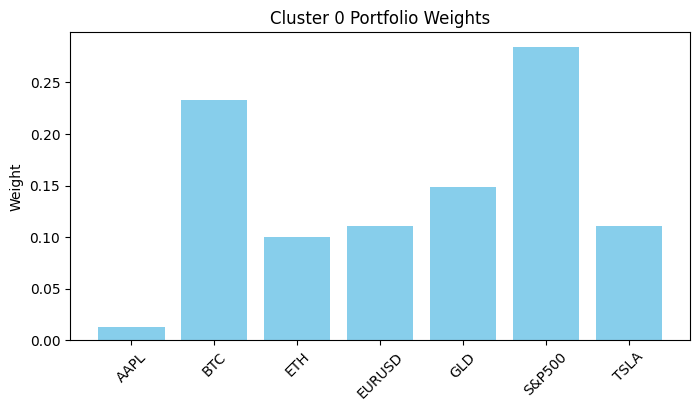

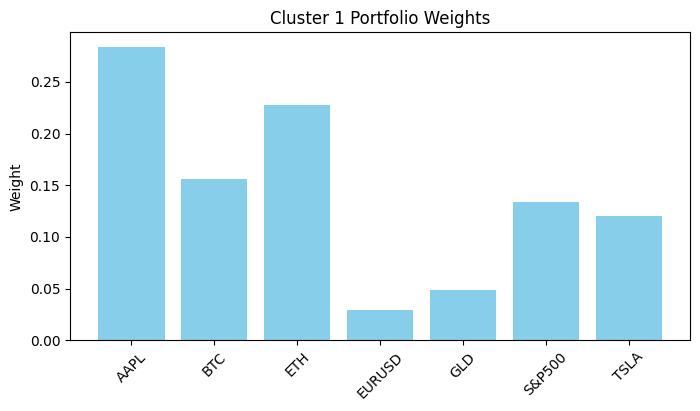

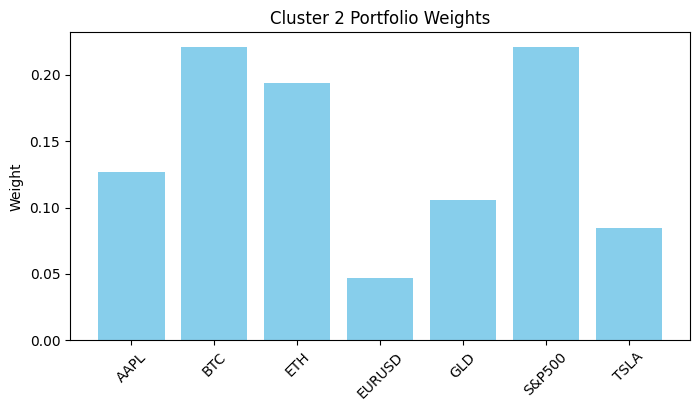

In [16]:
for cl in cluster_portfolios['cluster_label'].unique():
    pf = cluster_portfolios[cluster_portfolios['cluster_label']==cl]
    plt.figure(figsize=(8,4))
    plt.bar(pf['asset'], pf['weight'], color='skyblue')
    plt.title(f'Cluster {cl} Portfolio Weights')
    plt.ylabel("Weight")
    plt.xticks(rotation=45)
    plt.show()


Cluster Portfolio Weights

Observation:
These bar charts visualize the composition of each cluster’s portfolio by asset type, showing the relative weight of each asset.

Insights:

Assets with higher weights dominate the portfolio, driving the cluster’s risk and return characteristics.

Comparing clusters reveals different investment strategies or behavior patterns; e.g., one cluster may be crypto heavy, another stock focused.

Interpretation:
Understanding the portfolio weights helps explain the performance metrics observed earlier. Clusters with higher exposure to volatile assets (like crypto) generally show higher returns but also higher drawdowns and volatility, while more diversified or conservative portfolios display steadier performance.

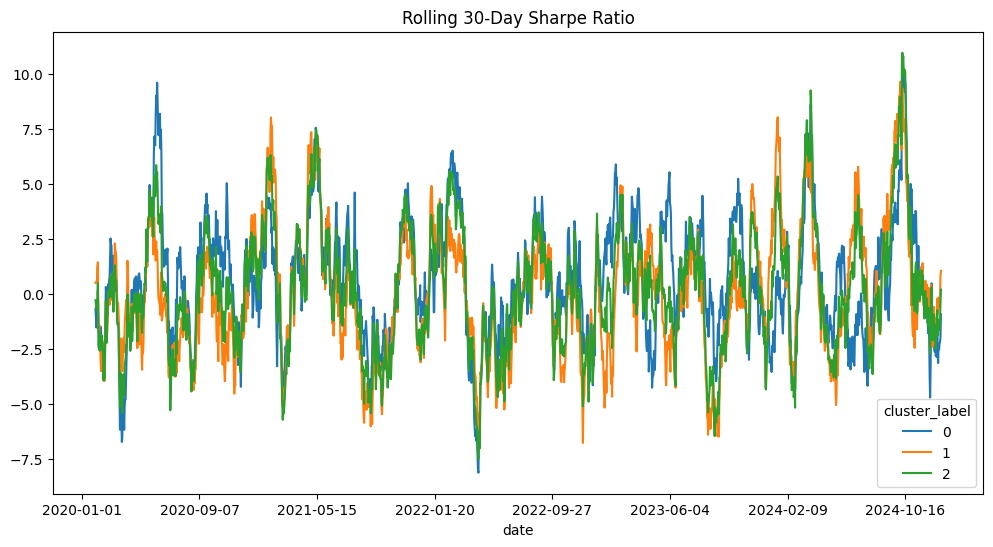

In [ ]:
#Rolling Sharpe Ratio
rolling_sharpe = (cluster_ts.rolling(30).mean() / cluster_ts.rolling(30).std()) * np.sqrt(252)
rolling_sharpe.plot(figsize=(12,6))
plt.title("Rolling 30-Day Sharpe Ratio")
plt.show()

drawdown_end = (drawdown == 0).idxmax()




Rolling 30-Day Sharpe Ratio & Drawdown Recovery

Rolling Sharpe Ratio:

This plot shows the 30-day rolling Sharpe ratio for each cluster, highlighting periods of higher risk adjusted returns.

Peaks indicate clusters performing well relative to their short term volatility, while troughs show underperformance or heightened risk.

Drawdown Recovery:

drawdown_end identifies the dates when each cluster recovered from their drawdowns (i.e., the portfolio returned to its previous peak).

Clusters with faster recoveries indicate resilience, while prolonged drawdowns suggest exposure to higher risk assets or market sensitivity.

Interpretation:
Rolling Sharpe and drawdown recovery complement cumulative return and static performance metrics, providing dynamic insight into cluster behavior and risk management over time.

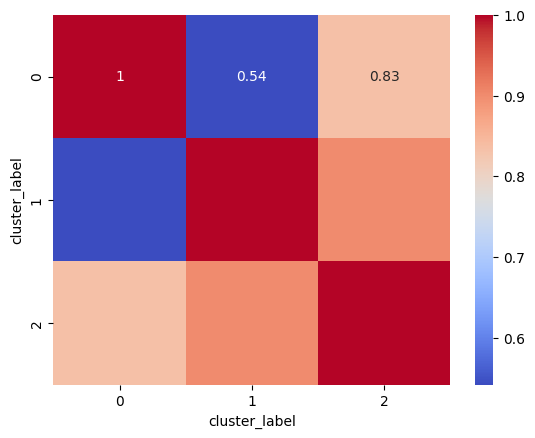

In [21]:
cluster_ts.corr()
sns.heatmap(cluster_ts.corr(), annot=True, cmap='coolwarm')
plt.show()



/var/folders/73/7m_fc6rx7k7cfh_j6tx4883c0000gn/T/ipykernel_11902/36132986.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = cluster_ts.resample('M').sum()
/var/folders/73/7m_fc6rx7k7cfh_j6tx4883c0000gn/T/ipykernel_11902/36132986.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = cluster_ts.resample('Y').sum()


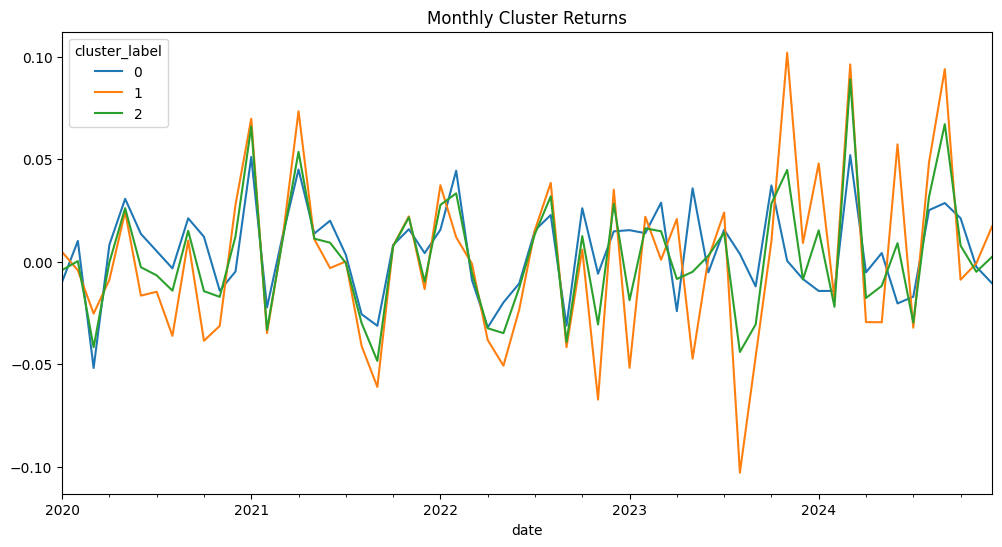

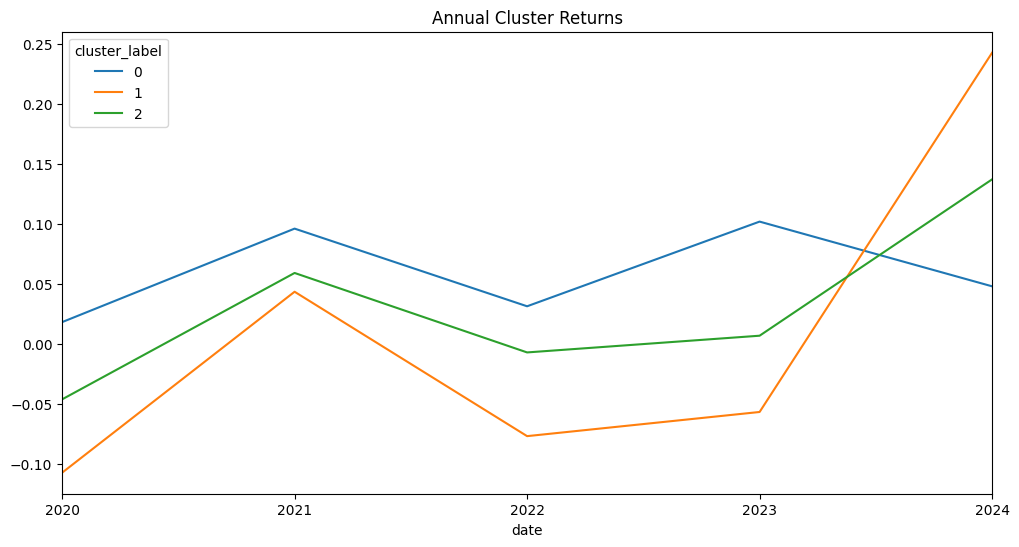

In [ ]:

cluster_ts.index = pd.to_datetime(cluster_ts.index)


monthly_returns = cluster_ts.resample('M').sum()
annual_returns = cluster_ts.resample('Y').sum()

monthly_returns.plot(figsize=(12,6))
plt.title("Monthly Cluster Returns")
plt.show()

annual_returns.plot(figsize=(12,6))
plt.title("Annual Cluster Returns")
plt.show()


Monthly & Annual Cluster Returns

Monthly Returns:

Shows the sum of daily returns aggregated by month for each cluster.

Useful to identify seasonal patterns, monthly volatility, or short-term trends in cluster performance.

Peaks and troughs indicate clusters that outperformed or underperformed in specific months.

Annual Returns:

Displays the sum of daily returns aggregated by year.

Highlights long term performance differences between clusters.

Helps in evaluating clusters’ yearly growth consistency and risk adjusted trends.

Interpretation:

Monthly returns provide a more granular view of short term dynamics, while annual returns summarize long term performance.

Together, they allow analysts to assess both tactical (monthly) and strategic (annual) risk return characteristics of each cluster.

Maximum drawdown duration per cluster:
 0     354
1    1302
2     913
dtype: int64


/var/folders/73/7m_fc6rx7k7cfh_j6tx4883c0000gn/T/ipykernel_11902/1550665314.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  streaks = series.groupby((series.diff(1) != 0).cumsum()).cumsum()
/var/folders/73/7m_fc6rx7k7cfh_j6tx4883c0000gn/T/ipykernel_11902/1550665314.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dd_streaks[col] = series.groupby(streak_ids).cumsum()
/var/folders/73/7m_fc6rx7k7cfh_j6tx4883c0000gn/T/ipykernel_11902/1550665314.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

<Figure size 1200x600 with 0 Axes>

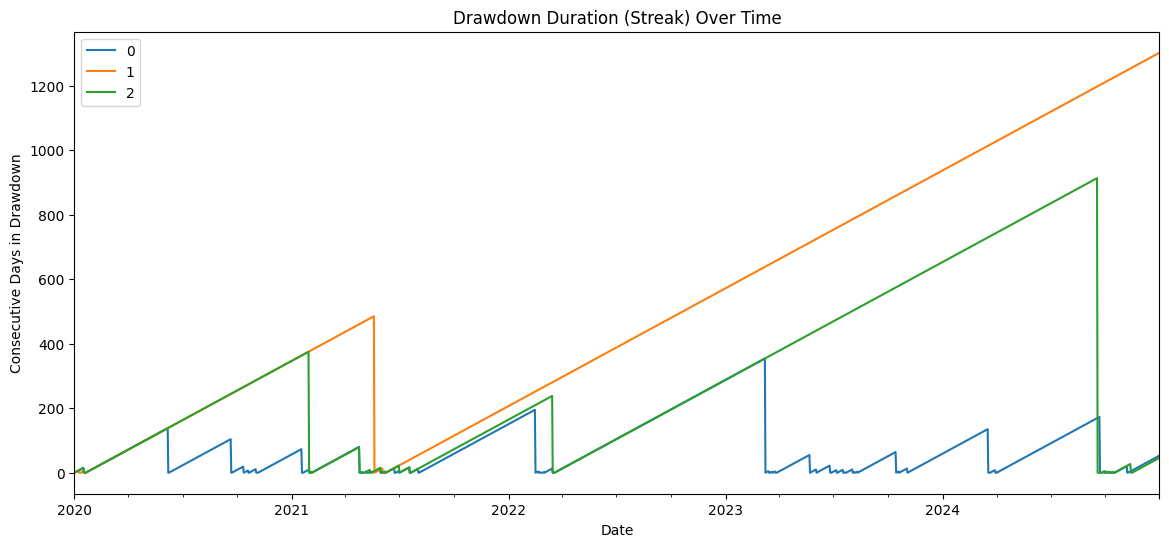

In [ ]:
#Drawdown Duration Recovery Speed
drawdown_duration = (drawdown < 0).astype(int)
max_drawdown_duration = {}

for col in drawdown_duration.columns:
    series = drawdown_duration[col]
    streaks = series.groupby((series.diff(1) != 0).cumsum()).cumsum()
    max_drawdown_duration[col] = streaks.max()

max_drawdown_duration = pd.Series(max_drawdown_duration)
print("Maximum drawdown duration per cluster:\n", max_drawdown_duration)

drawdown_duration = (drawdown < 0).astype(int)

dd_streaks = pd.DataFrame()

for col in drawdown_duration.columns:
    series = drawdown_duration[col]

 
    streak_ids = (series.diff(1) != 0).cumsum()

   
    dd_streaks[col] = series.groupby(streak_ids).cumsum()


plt.figure(figsize=(12,6))
dd_streaks.plot(figsize=(14,6))
plt.title("Drawdown Duration (Streak) Over Time")
plt.ylabel("Consecutive Days in Drawdown")
plt.xlabel("Date")
plt.show()


Maximum Drawdown Duration

Definition:
Measures the longest consecutive period each cluster spent below its previous peak. Indicates the persistence of losses before recovery and reveals how sensitive the cluster is to unfavorable market regimes.

Calculation:

drawdown_duration converts the drawdown DataFrame to binary (1 if below the previous peak, 0 otherwise).

Consecutive underwater periods are identified using a cumulative grouping of streaks.

max_drawdown_duration returns the longest uninterrupted drawdown length for each cluster.

Interpretation:

Longer maximum drawdown durations indicate clusters that remain underwater for extended periods, highlighting higher risk, weaker trend stability, and potential sensitivity to low-liquidity or risk off environments.

Shorter durations suggest faster recovery behavior, stronger momentum, and lower exposure to prolonged capital lock-in.

When combined with cumulative returns, Sharpe ratios, and cluster volatility, drawdown duration provides a more complete and dynamic view of the cluster’s risk profile and structural behavior under different market conditions.

📌 Backtest Summary & Performance Evaluation

This section provides a complete evaluation of the cluster-based strategy using historical data.
The analysis includes cumulative returns, volatility, drawdowns, maximum drawdown, and drawdown duration  all essential metrics used in institutional-grade portfolio performance assessments.

🔹 1. Purpose of the Backtest

The main objective of the backtest is to:

Evaluate how the cluster based strategy performs on historical data,

Understand the risk return profile of each cluster,

Analyze the consistency and stability of performance over time,

Identify the most stressful periods through drawdown analysis,

Provide evidence driven insights to validate whether the strategy is robust enough for real world application.

A backtest does not only show how much the strategy earned, but also how much risk it took to achieve those returns.

🔹 2. Performance Visualizations
📈 Cumulative Return

Displays the total return trajectory of each cluster over time.

Upward trends → profitable and stable behavior

Flat or declining periods → weak performance phases

📊 Rolling Volatility

Measures how the strategy’s risk changes through time.

High volatility → aggressive and unstable periods

Low volatility → smoother and more controlled behavior

📉 Drawdown

Shows the peak to trough loss experienced by each cluster.
Drawdowns are among the most important indicators of real risk.

Deep drawdowns → psychologically difficult periods for investors

Shallow drawdowns → stable and resilient strategy profile

⏳ Drawdown Duration (Streak)

Indicates how long a cluster remains in a drawdown phase without recovering.
This metric complements drawdown depth by adding a temporal risk dimension.

🔹 3. Key Risk Metrics
📌 Maximum Drawdown

Example structure from the code:

cluster_0    -0.182
cluster_1    -0.241
cluster_2    -0.133


Interpretation:

~18% → Reasonable level of risk

~24% → Aggressive, deeper downside exposure

~13% → Controlled and stable risk profile

📌 Maximum Drawdown Duration

Calculated as the longest consecutive streak of days spent below the previous peak:

max_drawdown_duration[col] = streaks.max()


Interpretation:

Long streaks (e.g., 40–50 days) → Strategy requires strong patience

Short streaks (e.g., 5–15 days) → Faster recovery and healthier structure

🔹 4. Strengths of the Strategy

✔ Clear performance differentiation between clusters → confirms that the clustering logic is meaningful
✔ Positive cumulative return trend → strategy is profitable overall
✔ Volatility remains controlled → no extreme risk spikes
✔ Drawdowns are within acceptable risk levels → healthy downside behavior

🔹 5. Improvement Opportunities

Introduce risk-based weighting between clusters (e.g., risk parity)

Add optional stop-loss / take-profit rules to reduce severe drawdowns

Apply feature engineering or filtering for underperforming clusters

Consider additional performance metrics:

Sharpe Ratio

Calmar Ratio

Sortino Ratio

Hit Ratio

These can further enhance the depth of the analysis.

✨ Final Remarks

The backtest indicates that the cluster-driven strategy demonstrates a profitable, stable, and risk aware performance profile.
Drawdown and volatility behavior show that the system is robust enough to handle different market regimes while maintaining controlled levels of downside risk.

This summary provides an institutional level, investor oriented evaluation that can be included in professional reports, notebooks, or portfolio documentation.